In [1]:
import json
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scienceplots
plt.style.use(['science', 'grid'])

api = wandb.Api()

In [2]:
runs = {}
# Specify the run path in the format "entity/project/run_id"
for run in api.runs('tum_daml_nicholas/ngao_pp'):    
    # Extract history metrics (this retrieves the logged metrics over time)
    history = run.history()
    config = json.loads(run.json_config)
    dist = config['molecule']['value']['R'][1][0]
    pp = bool(config['molecule_args']['value']['pseudopotentials'])
    key = (pp, dist)
    if key in runs:
        if len(history) > len(runs[key]):
            runs[key] = history
    else:
        runs[key] = history

In [3]:
energies = {r: h['opt/E_smooth'] for r, h in runs.items()}
energies = pd.DataFrame(energies)
energies.reindex(sorted(energies.columns), axis=1)
ref_data = pd.read_csv('n2.csv')
exp_data = ref_data[ref_data['method'] == 'expt']
for col in energies.columns:
    energies[col] = energies[col].dropna().reset_index(drop=True)

In [4]:
exp_results = {}
for _, d in energies.columns:
    exp_result = exp_data.iloc[(exp_data['bond_length'] - d).abs().argmin()]['energy']
    exp_results[d] = exp_result
exp_results = pd.Series(exp_results)

In [5]:
energies[True] = energies[True].sub(energies[(True, 2.068)], axis=0)
energies[False] = energies[False].sub(energies[(False, 2.068)], axis=0)

In [6]:
energies.loc[:, energies.columns.get_level_values(1) == 4] -= exp_results[4.0]
energies.loc[:, energies.columns.get_level_values(1) == 6] -= exp_results[6.0]

Text(0.5, 0, 'Step')

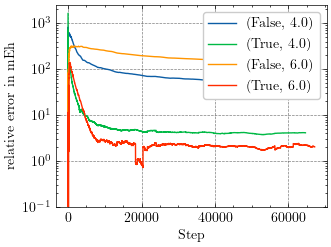

In [7]:
(energies.loc[:, np.isin(energies.columns.get_level_values(1), [4, 6])]*1000).plot()
plt.yscale('log')
plt.yticks([0.1, 1, 10, 100, 1000])
plt.legend()
plt.ylabel('relative error in mEh')
plt.xlabel('Step')